## 6.1.2　使用词嵌入

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


*  **加载IMDB 数据，准备用于Embedding 层**


In [0]:
from keras.datasets import imdb
from keras import preprocessing


#### 2. 使用预训练的词嵌入
## 6.1.3　整合在一起：从原始文本到词嵌入

In [0]:
import os

imdb_dir = '/content/drive'

In [0]:
!ls '/content/drive/My Drive/data/'

aclImdb.zip  cats_and_dogs_small  dogs-vs-cats.zip  train.zip
cat_cam.jpg  dogs-vs-cats	  test.zip


In [0]:
!unzip  aclImdb.zip  

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import os
os.chdir( "/content/drive/My Drive/data/")

In [0]:
!wget http://s3.amazonaws.com/text-datasets/aclImdb.zip  
! mv aclImdb.zip '/content/drive/My Drive/data/'

--2019-08-06 11:21:17--  http://s3.amazonaws.com/text-datasets/aclImdb.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.94.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.94.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60711700 (58M) [application/zip]
Saving to: ‘aclImdb.zip.1’

aclImdb.zip.1       100%[===================>]  57.90M  34.9MB/s    in 1.7s    

2019-08-06 11:21:19 (34.9 MB/s) - ‘aclImdb.zip.1’ saved [60711700/60711700]

/content/drive/My Drive/data/aclImdb.zip: Scheme missing.
FINISHED --2019-08-06 11:21:19--
Total wall clock time: 1.8s
Downloaded: 1 files, 58M in 1.7s (34.9 MB/s)


In [0]:

!pwd

/content/drive/My Drive/data


In [0]:
!ls 

aclImdb      cat_cam.jpg	  dogs-vs-cats	    __MACOSX  train.zip
aclImdb.zip  cats_and_dogs_small  dogs-vs-cats.zip  test.zip


In [0]:
len(os.listdir('aclImdb/train'))

5

In [0]:
!ls aclImdb/train

neg  pos  urls_neg.txt	urls_pos.txt




*   代码清单6-8　处理IMDB 原始数据的标签




In [0]:
imdb_dir = '/content/drive/My Drive/data/aclImdb'
train_dir = os.path.join(imdb_dir,'train')

labels = []
texts = []

for label_type in ['neg','pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)
          

## 2. 对数据进行分词
利用本节前面介绍过的概念，我们对文本进行分词，并将其划分为训练集和验证集。因为
预训练的词嵌入对训练数据很少的问题特别有用（否则，针对于具体任务的嵌入可能效果更好），
所以我们又添加了以下限制：将训练数据限定为前200 个样本。因此，你需要在读取200 个样
本之后学习对电影评论进行分类。

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [0]:
maxlen = 100 # 在100个单词后截断评论
training_samples = 200 # 在200个样本上训练
validation_samples = 10000#在10000个样本上验证
max_words = 10000 #只考虑数据集中前10000个最常见的单词

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 49012 unique tokens.


In [0]:
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:',data.shape)
print('Shape of label tensor:',labels.shape)

Shape of data tensor: (7558, 100)
Shape of label tensor: (7558,)


将数据划分为训练集和验证集，但首先
要打乱数据，因为一开始数据中的样本
是排好序的（所有负面评论都在前面，
然后是所有正面评论）

In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [0]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples +validation_samples]

### 3. 下载GloVe 词嵌入
打开https://nlp.stanford.edu/projects/glove，下载2014 年英文维基百科的预计算嵌入。这是
一个822 MB 的压缩文件，文件名是glove.6B.zip，里面包含400 000 个单词（或非单词的标记）
的100 维嵌入向量。解压文件。

In [0]:
!pwd
!wget http://nlp.stanford.edu/data/glove.6B.zip
!ls

/content/drive/My Drive/data
--2019-08-07 03:37:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-07 03:37:45--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-07 03:37:45--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Savin

In [0]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
!ls

aclImdb		     dogs-vs-cats	glove.6B.300d.txt  test.zip
aclImdb.zip	     dogs-vs-cats.zip	glove.6B.50d.txt   train.zip
cat_cam.jpg	     glove.6B.100d.txt	glove.6B.zip
cats_and_dogs_small  glove.6B.200d.txt	__MACOSX


In [0]:
!rm -rf __MACOSX
!mkdir glove.6B 
!mv glove.6B.* glove.6B
!ls

/bin/bash: mdir: command not found
mv: target 'glove.6B' is not a directory
aclImdb		     dogs-vs-cats	glove.6B.300d.txt  train.zip
aclImdb.zip	     dogs-vs-cats.zip	glove.6B.50d.txt
cat_cam.jpg	     glove.6B.100d.txt	glove.6B.zip
cats_and_dogs_small  glove.6B.200d.txt	test.zip


In [0]:
!mv glove.6B.* glove.6B
!ls

aclImdb      cat_cam.jpg	  dogs-vs-cats	    glove.6B  train.zip
aclImdb.zip  cats_and_dogs_small  dogs-vs-cats.zip  test.zip


### 4. 对嵌入进行预处理
我们对解压后的文件（一个.txt 文件）进行解析，构建一个将单词（字符串）映射为其向
量表示（数值向量）的索引。

- 解析GloVe 词嵌入文件

In [0]:
glove_dir = '/content/drive/My Drive/data/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


接下来，需要构建一个可以加载到Embedding 层中的嵌入矩阵。它必须是一个形状为
(max_words, embedding_dim) 的矩阵，对于单词索引（在分词时构建）中索引为i 的单词，
这个矩阵的元素i 就是这个单词对应的embedding_dim 维向量。注意，索引0 不应该代表任何
单词或标记，它只是一个占位符。
-　准备GloVe 词嵌入矩阵

In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector#嵌入索引（embeddings_index）中找不到的词，其嵌入向量全为0

### 5. 定义模型
我们将使用与前面相同的模型架构。

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense


In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

W0807 04:01:57.714223 139994951022464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 04:01:57.774788 139994951022464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 04:01:57.785842 139994951022464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 6. 在模型中加载GloVe 嵌入
Embedding 层只有一个权重矩阵，是一个二维的浮点数矩阵，其中每个元素i 是与索引i
相关联的词向量。够简单。将准备好的GloVe 矩阵加载到Embedding 层中，即模型的第一层。

* 将预训练的词嵌入加载到Embedding 层中

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

W0807 04:07:02.103730 139994951022464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0807 04:07:02.107813 139994951022464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



此外，需要冻结Embedding 层（即将其trainable 属性设为False），其原理和预训练的卷
积神经网络特征相同，你已经很熟悉了。如果一个模型的一部分是经过预训练的（如Embedding
层），而另一部分是随机初始化的（如分类器），那么在训练期间不应该更新预训练的部分，以
避免丢失它们所保存的信息。随机初始化的层会引起较大的梯度更新，会破坏已经学到的特征。
### 7. 训练模型与评估模型
* 编译并训练模型。

In [0]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val,y_val))
model.save_weights('pre_trained_glove_model.h5')

W0807 04:10:34.074374 139994951022464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 04:10:34.104342 139994951022464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 200 samples, validate on 7358 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0950 - acc: 0.9350 - val_loss: 1.2177e-04 - val_acc: 1.0000
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 1.3196e-05 - acc: 1.0000 - val_loss: 1.2152e-04 - val_acc: 1.0000
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 1.2861e-05 - acc: 1.0000 - val_loss: 1.2102e-04 - val_acc: 1.0000
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 1.2378e-05 - acc: 1.0000 - val_loss: 1.2050e-04 - val_acc: 1.0000
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 1.1795e-05 - acc: 1.0000 - val_loss: 1.1896e-04 - val_acc: 1.0000
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 9.9929e-06 - acc: 1.0000 - val_loss: 1.1804e-04 - val_acc: 1.0000
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 9.3597e-06 - acc: 1.0000 - val_loss: 1.1691

In [0]:
!ls
!pwd

aclImdb      cat_cam.jpg	  dogs-vs-cats	    glove.6B  test.zip
aclImdb.zip  cats_and_dogs_small  dogs-vs-cats.zip  models    train.zip
/content/drive/My Drive/data


In [0]:
!mkdir models 
!mv pre_trained_glove_model.h5 models

接下来，绘制模型性能随时间的变化（见图6-5 和图6-6）。
* 　绘制结果

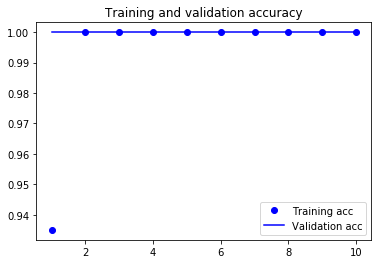

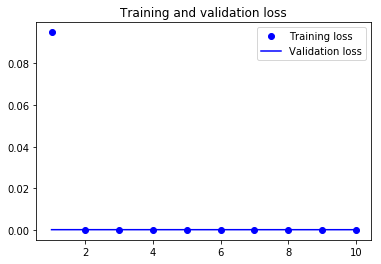

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### 在测试集上进行测试

* 对测试集数据进行分词

In [59]:
test_dir = os.path.join(imdb_dir,'test')

labels = []
tests = []

for label_type in ['neg','pos']:
  dir_name = os.path.join(test_dir, label_type)
  for fname in sorted(os.listdir(dir_name)):
    if fname[-4:] =='.txt':
      f = open(os.path.join(dir_name,fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)
        
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

OSError: ignored

In [58]:
!ls '/content/drive/My Drive/data/aclImdb/test/neg'

0_2.txt      11874_4.txt  2500_2.txt  4376_1.txt  6252_1.txt  8128_4.txt
10000_4.txt  11875_3.txt  2501_3.txt  4377_4.txt  625_2.txt   8129_4.txt
10001_1.txt  11876_4.txt  250_1.txt   4378_4.txt  6253_1.txt  8130_4.txt
10002_3.txt  11877_1.txt  2502_1.txt  4379_4.txt  6254_4.txt  8131_1.txt
10003_3.txt  11878_3.txt  2503_3.txt  4380_3.txt  6255_1.txt  813_1.txt
1000_3.txt   11879_2.txt  2504_3.txt  4381_3.txt  6256_2.txt  8132_3.txt
10004_2.txt  11880_3.txt  2505_1.txt  4382_3.txt  6257_4.txt  8133_4.txt
10005_2.txt  11881_2.txt  2506_1.txt  438_2.txt   6258_2.txt  8134_2.txt
10006_2.txt  11882_2.txt  2507_1.txt  4383_4.txt  6259_4.txt  8135_1.txt
10007_4.txt  1188_2.txt   2508_1.txt  4384_1.txt  6260_2.txt  8136_4.txt
10008_4.txt  11883_4.txt  2509_1.txt  4385_2.txt  6261_1.txt  8137_1.txt
10009_3.txt  11884_2.txt  2510_3.txt  4386_1.txt  6262_4.txt  8138_2.txt
10010_2.txt  11885_1.txt  2511_4.txt  4387_1.txt  6263_2.txt  8139_4.txt
10011_1.txt  11886_1.txt  2512_2.txt  4388_3.txt  62